# LAB 3: An illustration of End-to-end Machine Learning project

The purpose of this lab work is to predict median house values in Californian districts, given a number of features from these districts comprised in California housing prices dataset. Simple predictive models are built with Scikit-Learn (sklearn) library.

## Tasks 
1. Study and run (cell by cell) the code below which follows the main steps of a Machine Leaning process, in this case for predicting median house values. 

2. n_jobs in cross_val_score function used in this example code means how many jobs run in parallel while models are trained/evaluated with cross validation (CV). Find out in documentation what n_jobs=-1 means (google sklearn cross_val_score and you'll access the online documentation for sklearn library). What happens if you remove it, and why? (Hint: try to experiment and see why cross_val_score may last much longer by removing n_jobs). 

3. A Nearest Neighbour model (k=1 neighbours) always trivially overfits the training set, as seen also in this application below. Explain why, based on the understanding on how this algorithm works.

4. Evaluate the k-Nearest Neighbour models for k=1, k=3, k=5 (k is n_neighbors in sklearn library) within cross validation (CV).

5. Several simple models are trained in this example application. Which of them overfit most the training set? Rank them from the most overfitting to the least overfitting. (Hint: See the differences in errors models make on the training set compared to cross validation). 

6. Tune (optimise) the k-Nearest Neighbour model with a grid for k (k is n_neighbors in the code) between 1 and 10. What is the optimal value for the number of neighbours? 


# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed, as well as Scikit-Learn ≥0.20.

In [119]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the Data

## Download the Data

In [120]:
import os # Allowing python to interact with the native OS 
import tarfile # To process tgz files 
import urllib.request # To get data from url's

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [121]:
fetch_housing_data()

In [122]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path) 
# csv, comma seperated values, being loaded into a dataframe using panda

## Take a Quick Look at the Data Structure

In [123]:
# the outcome variable (to predict) is median_house_value;
# note that the median_income is in units of 10k
housing = load_housing_data()
housing.head() # returns the first n rows for the object based on position

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [124]:
housing.info() # panda function .info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [125]:
# notice that ocean_proximity is the only nominal/categorical variable, with the following counts on its values
housing["ocean_proximity"].value_counts() # Return a Series containing counts of unique values.

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [126]:
# here's a useful description of the data counts and distributions of variables
housing.describe() # count is jsut representing the number of elements in the column

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


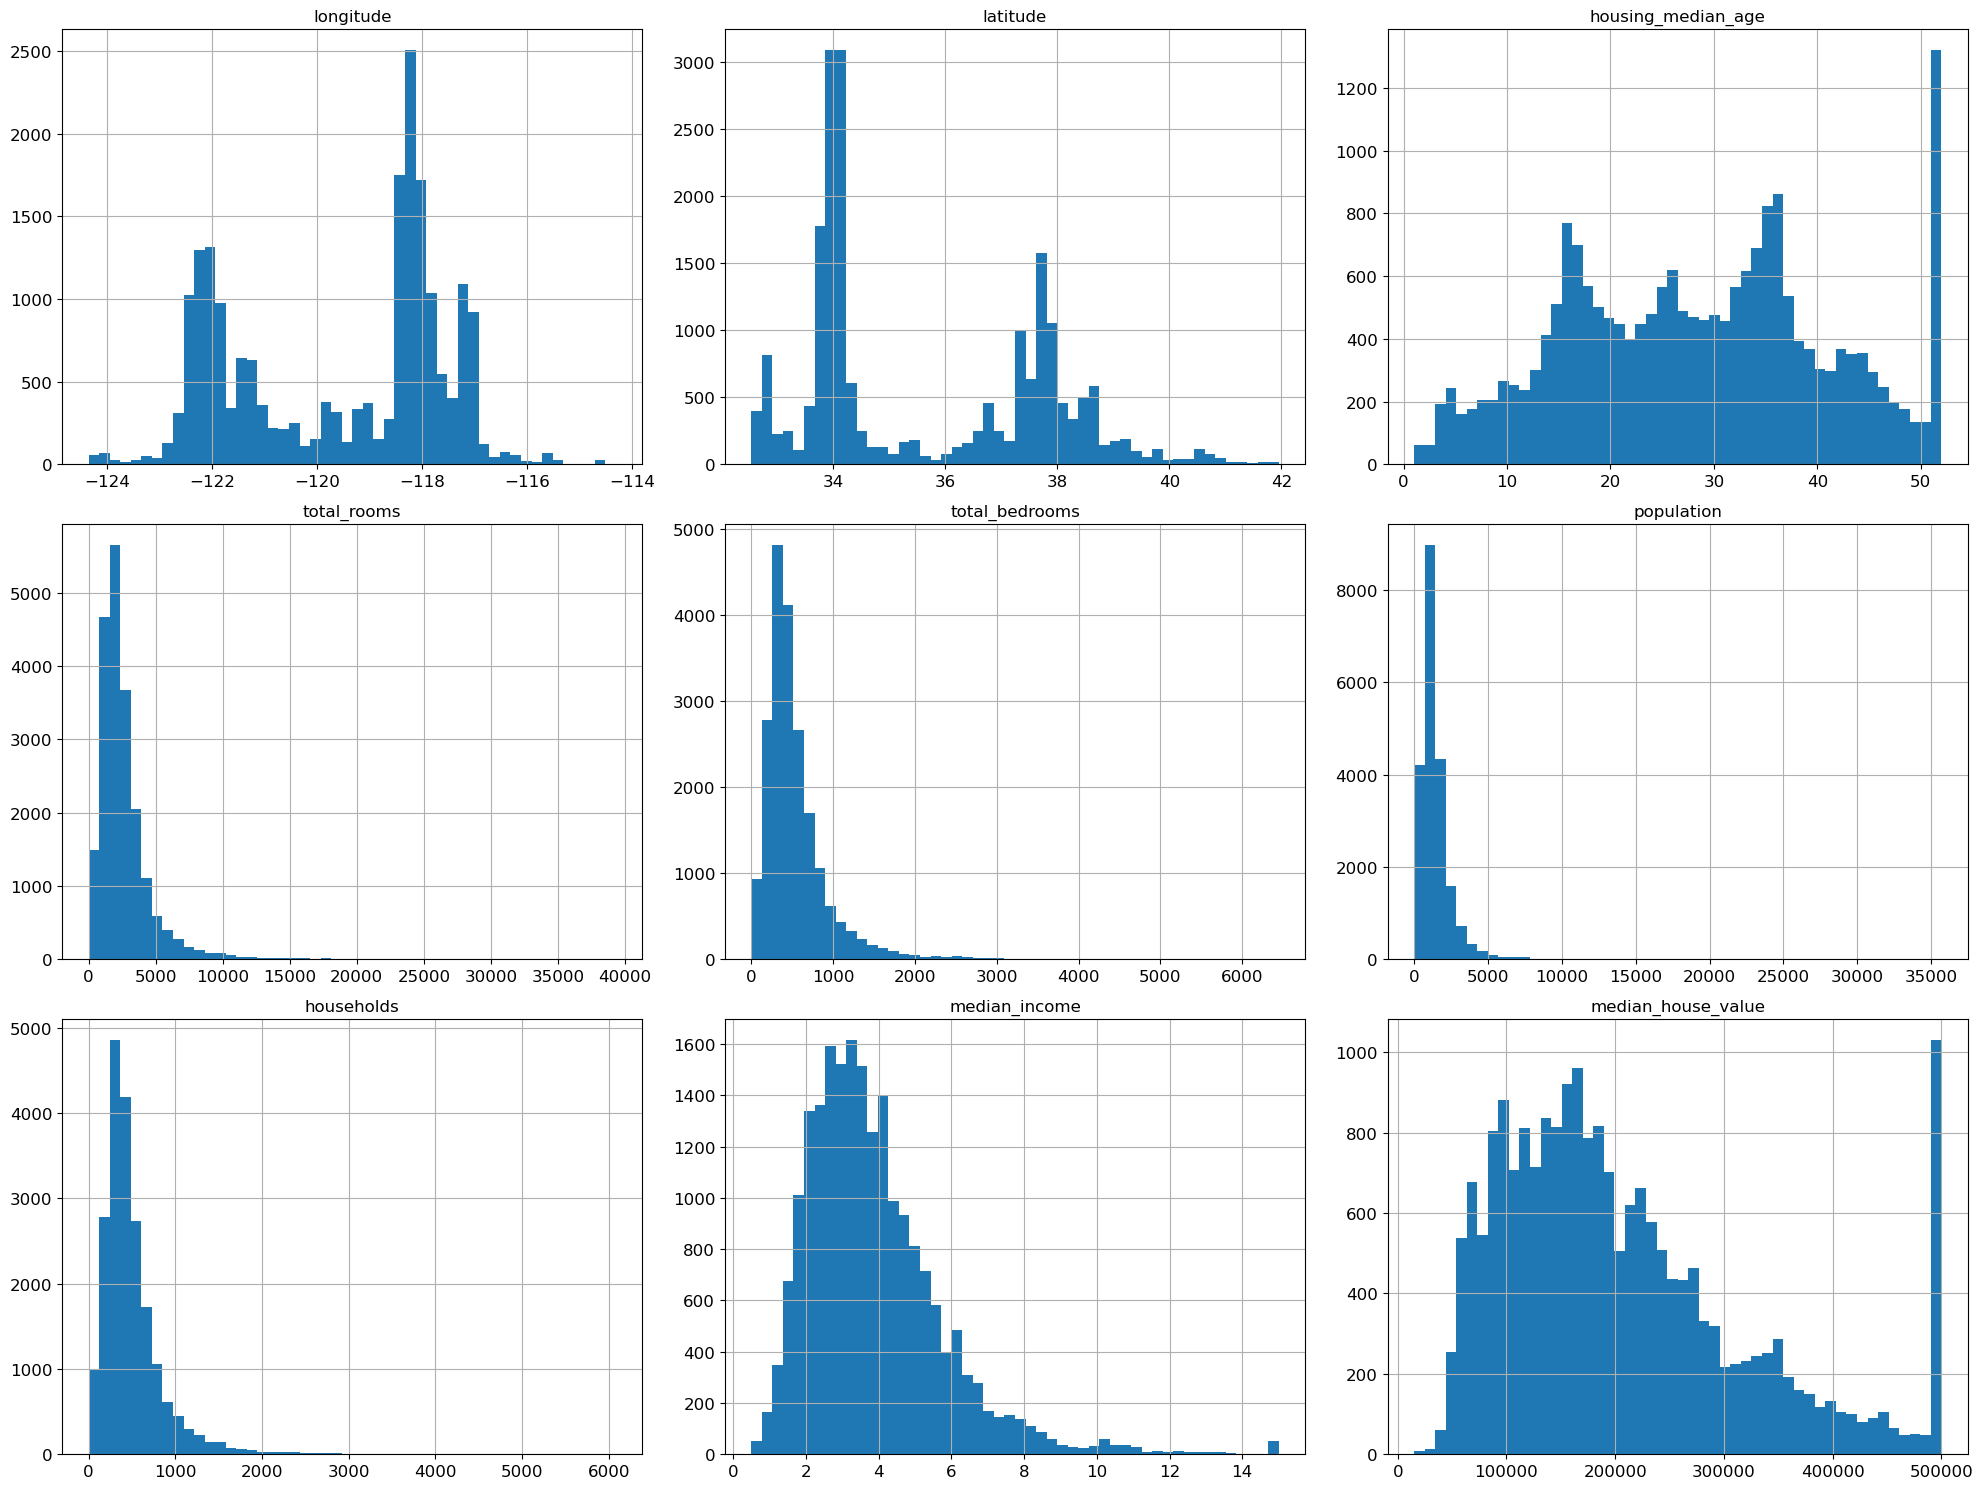

In [127]:
# let's visually inspect the data with histograms showing bars of frequencies of numeric values grouped in bins.

# What %matplotlib inline is doing.
# When using the 'inline' backend, your matplotlib graphs will be included in your notebook, next to the code.
%matplotlib inline
import matplotlib.pyplot as plt
# The total range of data set (i.e from minimum value to maximum value) is divided into 8 to 15 equal parts.
# These equal parts are known as bins or class intervals.
# It seems like bins determine how detailed you want your data to be in a historgram.
housing.hist(bins=50, figsize=(20,15)) # fig size = width, height of chart in pixels 
save_fig("attribute_histogram_plots") # just the name given to the saved file
plt.show()

## Create a Test Set

In [128]:
# to make this notebook's output identical at every run
np.random.seed(42) # makes the random numbers predictable.
# The same random numbers will be produced everytime if the seed is reset before random num generation.

In [129]:
# split the data into train and test sets, for model training and evaluation, respectively

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
# test_size= Should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split.
# random_state = Controls the shuffling applied to the data before applying the split.

In [130]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


<AxesSubplot: >

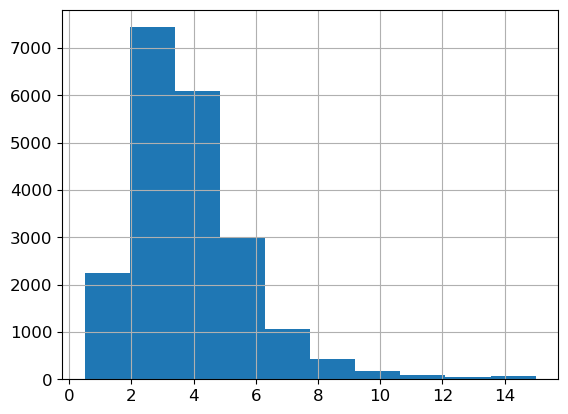

In [131]:
housing["median_income"].hist() # Setting bins to 50 will give us the same graph as above

In [132]:
# We build income categories (5) because we know that this variable is linked with the median house value, and use
# these categories to sample (once again) our data into training and test sets, proportionally with these categories 
# so this done in a stratified manner called stratified sampling

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
# Data binning, is a way to simplify and compress a column of data, by reducing the number of possible values or
#levels represented in the data.

In [133]:
housing["income_cat"].value_counts() # elements in each cat

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot: >

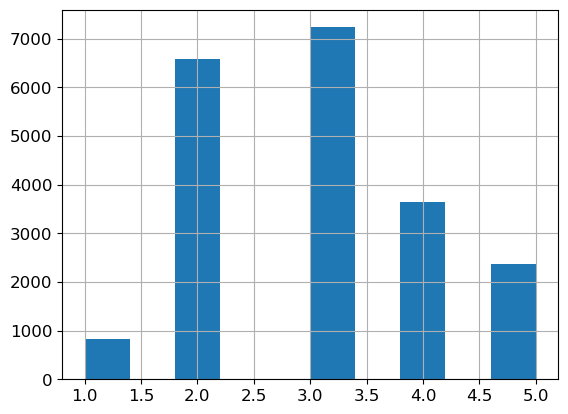

In [134]:
housing["income_cat"].hist()

In [135]:
# now we do stratified sampling on income_cat

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# As I understand it, we are further randomizing. This gives us random indices from the data frames given to it 
# according to the parameters set that we will use to further divide our data into further random formations.
# That is what .loc is doing, locating the value stored at the index that was generated.

In [136]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [137]:
housing["income_cat"].value_counts() / len(housing) # The point of these two divisions, I do not know.

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [138]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
# I don't know how many splits or randomization we need, we have 2 different test sets made from 'housing'

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index() # in ascending order by default 
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

# The formula he's using to calc the error I do not know or what error he's even finding out here for the random split
# set and the strat split set, what does it represent? I can see the error is lower in the strat set.

In [139]:
# Now we compare proportions of income_cat in the total dataset, and train and test sets obtained with stratified 
# and random sampling. 
# Observe that the stratified sampling leads to proportions similar to the total/overall dataset

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [140]:
# after stratified sampling using income_cat we drop this variable from the train and test datasets

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    
# Running this cell twice throws an error becase the set has already been dropped.

# Discover and Visualize the Data to Gain Insights

In [141]:
# make a copy of the training dataset
housing = strat_train_set.copy()

## Visualizing Geographical Data

Saving figure bad_visualization_plot


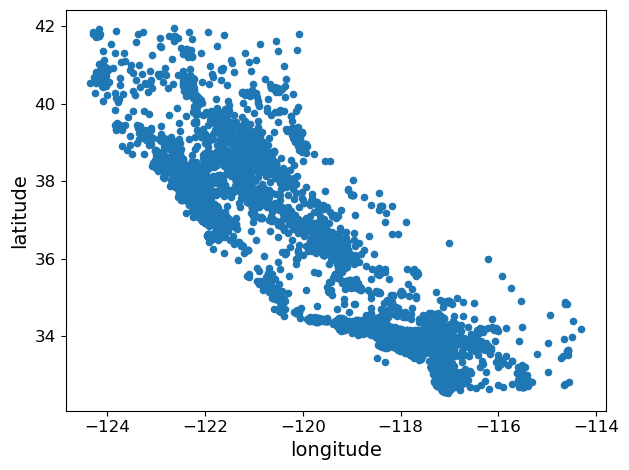

In [142]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


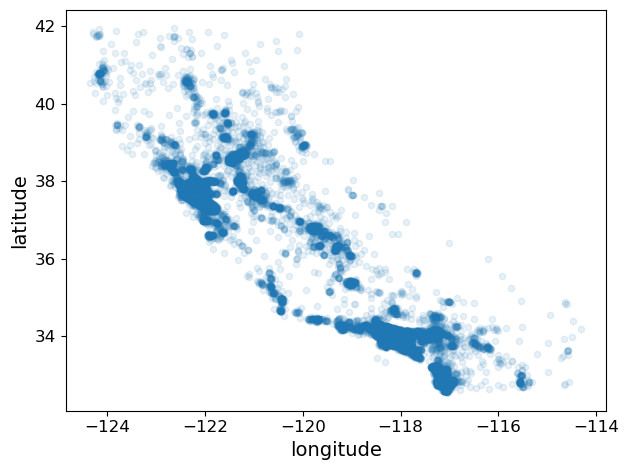

In [143]:
# showing data points with transparent circles controlled by parameter alpha, to detect areas densities 

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

Saving figure housing_prices_scatterplot


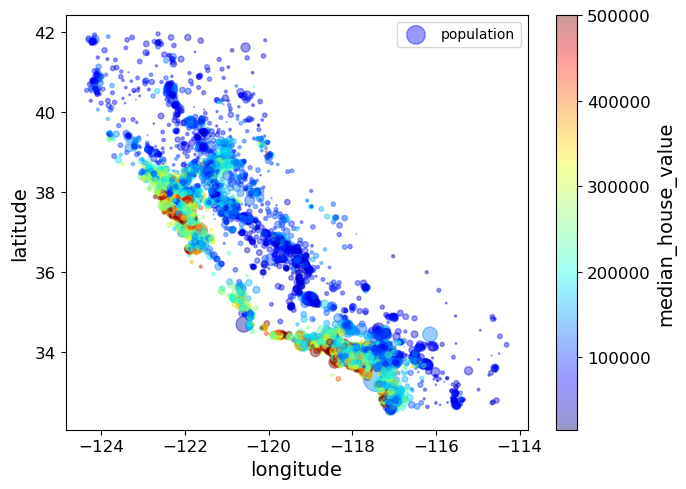

In [144]:
# representing median house value with colour, and size of population in districts with circle size. 

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(7,5),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
# c is just color of the bar on the right and cmap is just colourmap, while jet is just the color scheme defiend here.
# sharex is if the axis limits should be shared with another axis. 's' I am not sure, seems like a format string.
plt.legend()
save_fig("housing_prices_scatterplot")

In [145]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x29906bca0>)

Saving figure california_housing_prices_plot


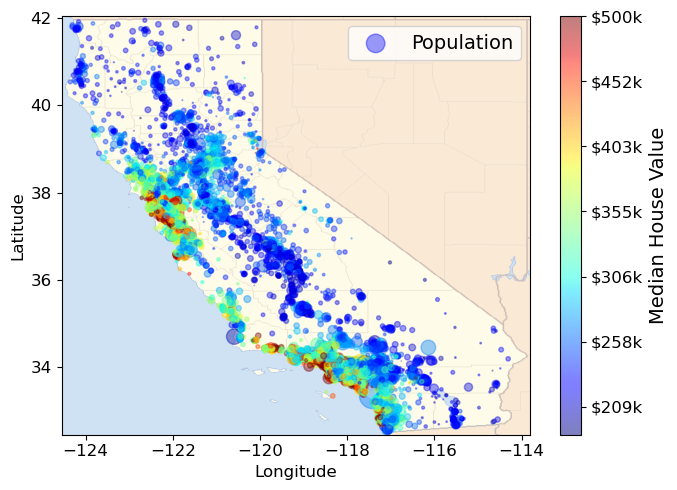

In [146]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename)) #imread, read image into array, from the cell above.
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(7,5),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
 # extent defines the coordinated the image will fill, here we used the axis values to stretch it along them.
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5, 
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=12)
plt.xlabel("Longitude", fontsize=12)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11) # Return evenly spaced numbers over a specified interval.
cbar = plt.colorbar(ticks=tick_values/prices.max()) # individually plotted.
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=12) 
# he's translating the raw pricing data into its real numericla values for the cbar.
cbar.set_label('Median House Value', fontsize=14)

plt.legend(fontsize=14)
save_fig("california_housing_prices_plot")
plt.show()

## Looking for Correlations

In [147]:
corr_matrix = housing.corr() # Compute pairwise correlation of columns, excluding NA/null values.

/var/folders/8y/nf6l7ky139zbydl7y38m6nzw0000gn/T/ipykernel_8325/2370208679.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr() # Compute pairwise correlation of columns, excluding NA/null values.


In [148]:
# we see that median income is mostly positively correlated with median house value.
# All values are being corelated against median hosue value, higher number means more coerealtion.

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


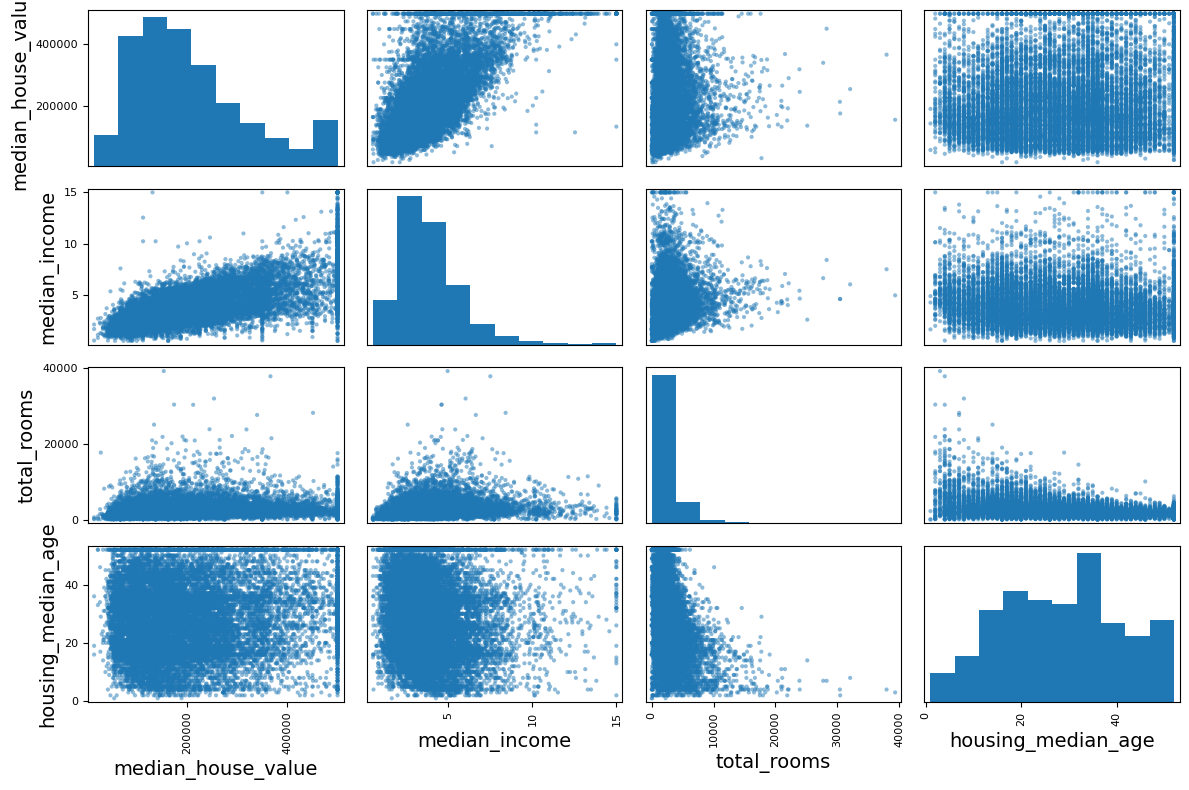

In [149]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


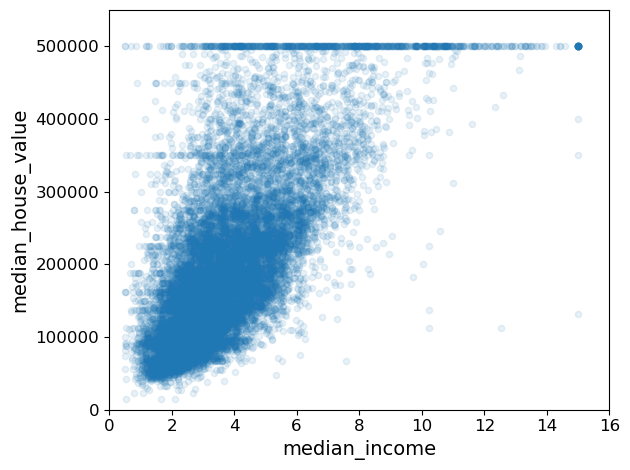

In [150]:

housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000]) # ([x range, y range])
save_fig("income_vs_house_value_scatterplot")

## Experimenting with Attribute/ Variable Combinations

In [151]:
# add new variables including rooms per household, as this may add more useful information than total rooms 
# variable in the dataset.

# I must admit, I'm not sure what data household is supoosed to represent, singular hosue?

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [152]:
# check again is any of the added variables show good/better correlation with outcome (target) variable,

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

/var/folders/8y/nf6l7ky139zbydl7y38m6nzw0000gn/T/ipykernel_8325/313426912.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

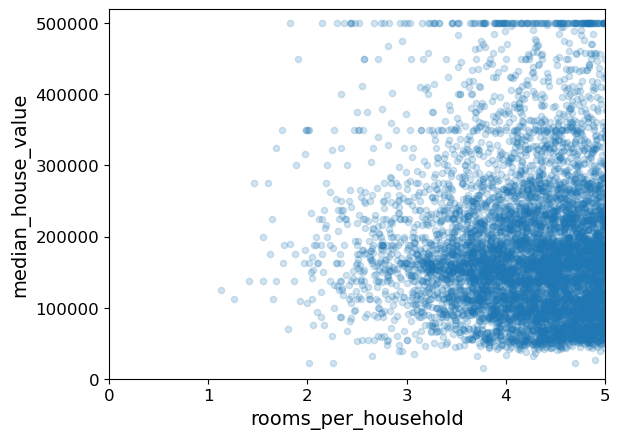

In [153]:
# observe the top horisontal line suggesting median house values are capped in this dataset to 500,000

housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [154]:
# notice the counts on variables, and the variable total_bedrooms which has a slightly smaller count 
# than other variables, so it contains missing values.
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare the Data for Machine Learning Algorithms

In [155]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

In the book 3 options are listed for missing values treatment:

```python
housing.dropna(subset=["total_bedrooms"])    # option 1 drop the rows with missing values, axis 0 for rows
housing.drop("total_bedrooms", axis=1)       # option 2 drop the column with missing values 
median = housing["total_bedrooms"].median()  # option 3 compute median and impute (fill in with median) the missing values 
housing["total_bedrooms"].fillna(median, inplace=True)
```

To demonstrate each of them, let's create a copy of the housing dataset, but keeping only the rows that contain at least one null. Then it will be easier to visualize exactly what each option does:

In [156]:
# note NaN which denote missing values, as seen in previous labs

# I do understand form the count above that the only columns possessing missing values are total bedrooms and
# bedrooms per room so I guess using columns as our search axis works.

sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [157]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [158]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [159]:
median = housing["total_bedrooms"].median() #  find median of entire column values.
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3, replace missing values with median.

In [160]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


In [161]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# An imputer, Replaces missing values using a descriptive statistic (e.g. mean, median, or most frequent) 
# along each column, or using a constant value.

Based on the training set, we now prepare an imputer with the median for all numeric variables, 
in case future data will have missing values on some of these variables.

Also remove the text attribute because median can only be calculated on numerical attributes:

In [162]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [163]:
# fit the imputer to the dataframe it is intended to work on 

imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [164]:
# shows the mdedians computed by the imputer, for each column
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Check that this is the same as manually computing the median of each attribute:

In [165]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Transform the training set:

In [166]:
X = imputer.transform(housing_num) # fills all the missing values with calc values.

In [167]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)
# I imagine it doesn't return a dataframe since he's making a new one

In [168]:
# now the mising values on total_bedrooms have been replaced by the median

housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


In [169]:
imputer.strategy

'median'

In [170]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, #housing_training basically
                          index=housing_num.index)

In [171]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


## Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`. We want to transform it to numeric data.
Two methids are mostly used, depending of the application: **ordinal encoding**, and **one-hot encoding**. 

In [172]:
housing_cat = housing[["ocean_proximity"]]

housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [173]:
# ordinal encoding is useful when the original data is ordered (not the case here)
# example of ordered nominal values: BSc < MSC < PhD in study variable in Goldsmiths Computing students dataset

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [174]:
ordinal_encoder.categories_ # It is worth noting that he is calling categories from the ordinal_encoder.

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [175]:
# One-hot encoding forms a new column for each category; 
# much more general than previous encoding, but generates several columns, filled in mostly with 0s, and a 1 for 
# the respective category.
# to save space, a sparse matrix is generated (returned).

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [176]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [177]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

/Users/umar/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [178]:
cat_encoder.categories_ # I guess a transformer just keeps a record of what it transformed.

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers

Let's create a custom transformer to add extra attributes:

In [179]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Note that I hard coded the indices (3, 4, 5, 6) for concision and clarity in the book, but it would be much cleaner to get them dynamically, like this:

In [180]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices, loc returns the indeces number.

Also, `housing_extra_attribs` is a NumPy array, we've lost the column names (unfortunately, that's a problem with Scikit-Learn). To recover a `DataFrame`, you could run this:
<br>
I take it the custom class we created can't return a dataframe back to us, it gave us a numpy arrry which is why we 
need to build our dataframe again with the new columns we've built. 

In [181]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


## Transformation Pipelines

Now let's build a pipeline for preprocessing the numerical attributes:

In [182]:
from sklearn.pipeline import Pipeline
# The purpose of the pipeline is to assemble several steps that can be cross-validated together
# while setting different parameters.
from sklearn.preprocessing import StandardScaler
# Standardize features by removing the mean and scaling to unit variance.

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [183]:
from sklearn.compose import ColumnTransformer
# Applies transformers to columns of an array or pandas DataFrame.

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [184]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [185]:
housing_prepared.shape

(16512, 16)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [186]:
# fitting a simple linear regression to predict the median house values

from sklearn.linear_model import LinearRegression

# Linear regression can work here because we've transformed our data into to linear shape(x,y).

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels) # housing label is our target (median house values). 

LinearRegression()

In [187]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 86208. 304704. 153536. 185728. 244416.]


Compare against the actual values:

In [188]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [189]:
some_data_prepared

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 ,  0.01739526,  0.00622264,
        -0.12112176,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
         0.53361152,  0.72131799,  1.292168  ,  0.56925554, -0.04081077,
        -0.81086696,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, -0.46977281, -0.54513828,
        -0.67467519, -0.52440722, -0.52543365, -0.01802432, -0.07537122,
        -0.33827252,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.22173797, -1.35147437, -0.37006852, -0.34865152, -0.03636724,
        -0.46761716, -0.03729672, -0.86592882, -0.59513997, -0.10680295,
         0.96120521,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.43743108, -0.63581817, -0

In [190]:
# let's see what rmse erroring the linear regression achieves on the training set

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68633.40810776998

**Note**: since Scikit-Learn 0.22, you can get the RMSE directly by calling the `mean_squared_error()` function with `squared=False`.

In [191]:
# another useful error is mean absolute error 
# (useful to consider when you suspect outliers in data as it's more robust to outliers than rmse)

from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49448.131359011626

In [192]:
# fitting a simple nearest neighbour regression to predict the median house values

from sklearn.neighbors import KNeighborsRegressor
neigh_reg = KNeighborsRegressor(n_neighbors=1)
neigh_reg.fit(housing_prepared, housing_labels) 
# By fitting our regression first, we let it know the data it needs to work on as well as what the actual
# target variables values are. Using the predict method gives us the predictions.

KNeighborsRegressor(n_neighbors=1)

In [193]:
# let's see what rmse erroring the nerest neighbour model achieves on training set;
# we can see here that this model clearly overfits the training set due to a 0 error;
# this is not surprising; why? (see relevant task from the beginning of this lab)

housing_predictions = neigh_reg.predict(housing_prepared)
neigh_mse = mean_squared_error(housing_labels, housing_predictions)
neigh_rmse = np.sqrt(neigh_mse)
neigh_rmse

0.0

In [194]:
# fitting a simple decision tree

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42) # random_state, Controls the randomness of the estimator.
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [195]:
# let's see what rmse error the decision tree achieves on training set;
# this is a powerful model which can capture non-linear patterns in the data
# and here clearly overfits the training set because of the error = 0

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [196]:
# fitting a simple random forest model consisting of an ensemble of 100 trees (n_estimators) 
# whose predictions are averaged by the random forest model;
# ensemble models, in particular random forests, are powerful as they combine the results produced by several models

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42) # estimators, number of trees in forest.
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [197]:
# evaluating the random forest model on the training set;

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse
# square rooting the mean square error does return the random mean square but we can also do it directly.

18650.698705770003

## Better Evaluation Using Cross-Validation (CV)

In [198]:
# first define a function to display (error) scores in a CV, on all test folds, and their average and 
# standard deviation.

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [199]:
# evaluating linear regression within CV, it shows a rmse error only very slightly larger than on training set
# very simple models such as linear regression models overfit much less on the data since they're not very flexible;
# still they can overfit if they are built on data that has many variables and not many enough data rows. 

from sklearn.model_selection import cross_val_score

# Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.
# The procedure has a single parameter called k (cv) that refers to the number of groups that a given data sample is 
# to be split into. As such, the procedure is often called k-fold cross-validation.

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             n_jobs=-1, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

# n_jobs, Number of jobs to run in parallel. Training the estimator and computing the score are parallelized 
# over the cross-validation splits.

Scores: [71800.38078269 64114.99166359 67844.95431254 68635.19072082
 66801.98038821 72531.04505346 73992.85834976 68824.54092094
 66474.60750419 70143.79750458]
Mean: 69116.4347200802
Standard deviation: 2880.6588594759014


In [200]:
# evaluating the decision tree within CV, we see a more reasonable rmse error (not 0 as on train set)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         n_jobs=-1, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [201]:
# evaluating random forest within CV, it shows a bigger rmse error than on training set so we can say it also
# overfitted the training set.

from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                n_jobs=-1, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

# Note, this takes a while to process and execute.

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


# Fine-Tune Your Model

## Grid Search

In [202]:
# tunning a random forest model; this is optimising the model over a set/grid of values for the hyperparameters.
# n_estimators is the number of trees whose predictions are averaged.
# max_features is the number of variables randomly selected to be evaluated in a node for predictive power; the best
# is used in the node.
# bootstrap means whether data points may be sampled with repetition (multiple times) for training.
# making this true would be bad because it would make the model process the same data over and over again.

from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
# Note that he set up the param grid seperately as a Dictionary, outside the object before passing it to the object
# as an argument.

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, n_jobs=-1,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best hyperparameter combination found:

In [203]:
# I guess thats what it does, finds us the best combination of features and estimators that results in the best score.
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [204]:
# methods of the grid search class
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [205]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52891.66240619666 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [206]:
# here are the cross validation results in full as a dataframe

pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.061604,0.002352,0.002559,0.000460,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.119912e+09,-3.723465e+09,...,-4.082592e+09,1.867375e+08,18,-1.155630e+09,-1.089726e+09,-1.153843e+09,-1.118149e+09,-1.093446e+09,-1.122159e+09,2.834288e+07
1,0.194183,0.005361,0.011712,0.004493,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.973521e+09,-2.810319e+09,...,-3.015803e+09,1.139808e+08,11,-5.982947e+08,-5.904781e+08,-6.123850e+08,-5.727681e+08,-5.905210e+08,-5.928894e+08,1.284978e+07
2,0.577171,0.004516,0.023421,0.002339,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.801229e+09,-2.671930e+09,...,-2.797528e+09,8.014389e+07,9,-4.412567e+08,-4.324781e+08,-4.553722e+08,-4.320746e+08,-4.315783e+08,-4.385520e+08,9.140206e+06
3,0.098778,0.001427,0.003158,0.000910,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.528743e+09,-3.490303e+09,...,-3.609050e+09,1.375683e+08,16,-9.782368e+08,-9.806455e+08,-1.003780e+09,-1.016515e+09,-1.011270e+09,-9.980896e+08,1.577372e+07
4,0.318787,0.012291,0.008806,0.002419,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.742620e+09,-2.609311e+09,...,-2.755726e+09,1.182604e+08,7,-5.063215e+08,-5.257983e+08,-5.081984e+08,-5.174405e+08,-5.282066e+08,-5.171931e+08,8.882622e+06
5,1.006237,0.029064,0.024127,0.001165,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.522176e+09,-2.440241e+09,...,-2.518759e+09,8.488084e+07,3,-3.776568e+08,-3.902106e+08,-3.885042e+08,-3.830866e+08,-3.894779e+08,-3.857872e+08,4.774229e+06
6,0.124448,0.004124,0.003431,0.001007,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.362127e+09,-3.311863e+09,...,-3.371513e+09,1.378086e+08,13,-8.909397e+08,-9.583733e+08,-9.000201e+08,-8.964731e+08,-9.151927e+08,-9.121998e+08,2.444837e+07
7,0.450744,0.011143,0.008543,0.001397,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.622099e+09,-2.669655e+09,...,-2.654240e+09,6.967978e+07,5,-4.939906e+08,-5.145996e+08,-5.023512e+08,-4.959467e+08,-5.147087e+08,-5.043194e+08,8.880106e+06
8,1.367452,0.020271,0.025111,0.000979,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.446142e+09,-2.446594e+09,...,-2.496981e+09,7.357046e+07,2,-3.760968e+08,-3.876636e+08,-3.875307e+08,-3.760938e+08,-3.861056e+08,-3.826981e+08,5.418747e+06
9,0.183701,0.002992,0.003968,0.001749,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.590333e+09,-3.232664e+09,...,-3.468718e+09,1.293758e+08,14,-9.505012e+08,-9.166119e+08,-9.033910e+08,-9.070642e+08,-9.459386e+08,-9.247014e+08,1.973471e+07


## Randomized Search

In [207]:
# tune a random forest model in randomized search cross validation for the best hyperparameter values in 10 iterations
# 10 combinations chosen randomly of hyperparameter values will be attempted

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': [20, 200], # this means it'll only use 20 or 200 trees, no in betweens.
        'max_features': randint(low=2, high=16),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_jobs=-1, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x298c6fa60>,
                                        'n_estimators': [20, 200]},
                   random_state=42, scoring='neg_mean_squared_error')

In [208]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49186.59493765748 {'max_features': 8, 'n_estimators': 200}
51257.54260678808 {'max_features': 14, 'n_estimators': 20}
49672.962433513036 {'max_features': 12, 'n_estimators': 200}
51257.54260678808 {'max_features': 14, 'n_estimators': 20}
49186.59493765748 {'max_features': 8, 'n_estimators': 200}
50597.67417016068 {'max_features': 4, 'n_estimators': 20}
51201.643299751435 {'max_features': 12, 'n_estimators': 20}
50577.557186597835 {'max_features': 9, 'n_estimators': 20}
49157.05545157302 {'max_features': 5, 'n_estimators': 200}
50577.557186597835 {'max_features': 9, 'n_estimators': 20}


## Analyze the Best Models and Their Errors
#Feature Importance refers to techniques that calculate a score for all the input features for a given model — the scores simply represent the “importance” of each feature. A higher score means that the specific feature will have a larger effect on the model that is being used to predict a certain variable.

In [212]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

# best_estimator, Estimator that was chosen by the search, i.e. estimator which gave highest score
# (or smallest loss if specified).

array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03])

In [216]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

# I must admit, I'm not sure how the models are being evaluated here, they're all randomforest regressor

[(0.3790092248170966, 'median_income'),
 (0.16570630316895874, 'INLAND'),
 (0.10703132208204355, 'pop_per_hhold'),
 (0.06965425227942927, 'longitude'),
 (0.060421384008072176, 'latitude'),
 (0.05477891501828372, 'rooms_per_hhold'),
 (0.0482031213382692, 'bedrooms_per_room'),
 (0.04218822024391752, 'housing_median_age'),
 (0.01584911474442863, 'population'),
 (0.015554529490469331, 'total_bedrooms'),
 (0.015245055688409767, 'total_rooms'),
 (0.014934655161887769, 'households'),
 (0.006792660074259964, '<1H OCEAN'),
 (0.0030281610628962743, 'NEAR OCEAN'),
 (0.001524732755550493, 'NEAR BAY'),
 (7.8348066026875e-05, 'ISLAND')]

## Evaluate Your System on the Test Set

In [215]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [217]:
final_rmse

47873.26095812988

## Can we combine preparation/preprocessing and prediction in same pipeline?

In [218]:
# Yes: A full pipeline with both preparation and prediction

full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([ 86208., 304704., 153536., 185728., 244416.])

## Model persistence using joblib

In [219]:
my_model = full_pipeline_with_predictor

In [220]:
# saving and recovering a model
# you can use this to share models

import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Potential improvements of the ML modelling

After a cycle of data preprocessing and model training/ tuning, the Machine Learning engineer / analyst can return at different stages of the ML process to make improvements if needed, and redo the process. 

For instance: (a) Dropping some features which have close to 0 correlations with the outcome. (b) And/or choosing the best features - with the highest importance from the random forest model.

These operations are called Feature selection. Feature selection is very useful especially when the dataset has a large number of variables (not the case here), or we use algos that are sensitive to features which are not predictive, as it is the case of k-Nearest Neighbour.

## Final remarks

This application of predicting house prices is based on a regression problem, so we used a simple form of regression algos to illustrate this ML analysis process. Some of the algos used here for regression, k-Nearest Neighbour, Decision Trees, Random Forest, have their versions for classification also. Their corresponding classes in sklearn are, respectively: KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier.

For instance here is how to fit a Random Forest classifier:

    from sklearn.ensemble import RandomForestClassifier

    forest_cl = RandomForestClassifier(n_estimators=500, random_state=40)

    forest_cl.fit(training_set, training_labels)